In [40]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)

In [2]:
df = pd.read_csv('house.csv')
df.head()

,bedroom_count,net_sqm,center_distance,metro_distance,floor,age,price
0,1,26.184098,1286.68,204.003817,22,67,96004.804557
1,1,34.866901,1855.25,186.980360,8,30,92473.722568
2,1,36.980709,692.09,111.224999,24,24,98112.519942
3,1,17.445723,1399.49,237.998760,1,66,92118.326874
4,1,52.587646,84.65,100.996400,20,3,98976.653176


In [43]:
df.describe()

,bedroom_count,net_sqm,center_distance,metro_distance,floor,age,price
count,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000
mean,3.732823,118.941327,1090.544301,105.665358,9.397168,48.576834,95701.196185
std,2.476989,95.469802,555.325830,60.750825,7.517018,27.621465,3919.823988
min,1.000000,10.244518,11.800000,1.245338,1.000000,0.000000,86113.592974
25%,2.000000,52.240659,635.897500,56.156897,2.000000,25.000000,92934.251436
50%,3.000000,91.828201,1143.135000,101.388012,8.000000,48.000000,95337.792918
75%,5.000000,150.987591,1554.280000,148.481068,16.000000,72.000000,97980.675094
max,17.000000,750.971604,1999.840000,330.275317,24.000000,97.000000,118134.771190


In [3]:
df['bedroom_count_grouped'] = df['bedroom_count'].apply(lambda x: x if x < 10 else '10+')
df_grouped = df.groupby('bedroom_count_grouped')['price']
price_data_by_bedrooms = [group for _, group in df_grouped]
group_analysis_merged = pd.DataFrame({
    'Sample Count': df_grouped.count(),
    'Variance': df_grouped.var()
})
group_analysis_merged

,Sample Count,Variance
bedroom_count_grouped,,
1,612,7.290650e+06
2,1130,8.501346e+06
3,781,8.923768e+06
4,588,1.071874e+07
5,301,1.133771e+07
6,258,1.442870e+07
7,186,1.287068e+07
8,156,1.771164e+07
9,140,1.731087e+07


In [4]:
bartlett_result = stats.bartlett(*price_data_by_bedrooms)
bartlett_result

BartlettResult(statistic=219.14294857226892, pvalue=3.169397674040137e-42)

In [5]:
def cochran_c_test(*args):
    variances = [np.var(a, ddof=1) for a in args]
    max_variance = max(variances)
    sum_variances = sum(variances)
    C = max_variance / sum_variances
    return C

cochran_c_result = cochran_c_test(*price_data_by_bedrooms)
cochran_c_result

0.1902277226687444

In [6]:
log_price_data_by_bedrooms = [np.log(group + 1) for group in price_data_by_bedrooms]
bartlett_stat_transformed, bartlett_p_transformed = stats.bartlett(*log_price_data_by_bedrooms)
bartlett_stat_transformed, bartlett_p_transformed

(158.87803607530577, 1.2701629783538752e-29)

In [26]:
X = df[['bedroom_count', 'net_sqm', 'center_distance', 'metro_distance', 'floor', 'age']]
y = df['price']

In [27]:
sm.stats.diagnostic.het_goldfeldquandt(y, X, idx=0, drop=0.2)

(0.8429282740148406, 0.9997238150809711, 'increasing')

In [33]:
results_ols = sm.OLS(y, sm.add_constant(X)).fit()
results_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     1835.
Date:                Sat, 16 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:34:10   Log-Likelihood:                -39021.
No. Observations:                4308   AIC:                         7.806e+04
Df Residuals:                    4301   BIC:                         7.810e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             9.46e+04    129.991    727.773      0.000    9.43e+04    9.49e+04
bedroom_count     308.5671     21.016     14.682      0.000     267.364     349.770
net_sqm            25.1994      0.505     49.909      0.000      24.209      26.189
center_distance    -3.3608      0.070    -47.908      0.000      -3.498      -3.223
metro_distance      6.9984      0.642     10.909      0.000       5.741       8.256
floor             121.6607      4.989     24.385      0.000     111.880     131.442
age               -26.1286      1.149    -22.739      0.000     -28.381     -23.876
==============================================================================
Omnibus:                      641.697   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7305.816
Skew:                          -0.321   Prob(JB):                         0.00
Kurtosis:                       9.347   Cond. No.                     5.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
weights = 1 / (results_ols.fittedvalues ** 2)

results_wls = sm.WLS(y, sm.add_constant(X), weights=weights).fit()
results_wls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.716
Model:                            WLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     1806.
Date:                Sat, 16 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:36:35   Log-Likelihood:                -38960.
No. Observations:                4308   AIC:                         7.793e+04
Df Residuals:                    4301   BIC:                         7.798e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            9.458e+04    128.359    736.877      0.000    9.43e+04    9.48e+04
bedroom_count     296.5598     20.911     14.182      0.000     255.564     337.556
net_sqm            25.6590      0.514     49.884      0.000      24.651      26.667
center_distance    -3.3877      0.069    -48.842      0.000      -3.524      -3.252
metro_distance      7.3604      0.633     11.636      0.000       6.120       8.601
floor             122.1195      4.890     24.975      0.000     112.533     131.706
age               -26.1996      1.132    -23.137      0.000     -28.420     -23.979
==============================================================================
Omnibus:                      547.852   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6076.666
Skew:                          -0.126   Prob(JB):                         0.00
Kurtosis:                       8.813   Cond. No.                     5.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

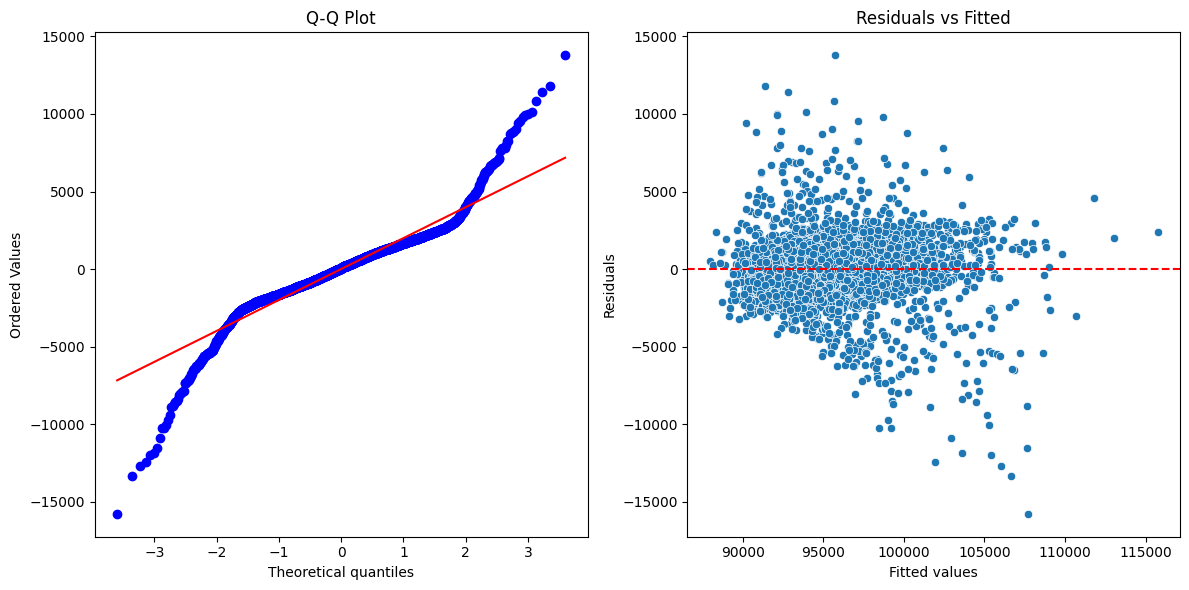

1.955987161959417

In [39]:
residuals = results_ols.resid

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.subplot(1, 2, 2)
sns.scatterplot(x=results_ols.fittedvalues, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

durbin_watson_statistic = sm.stats.stattools.durbin_watson(residuals)

durbin_watson_statistic

